In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['font.family'] = 'SimHei' 
plt.rcParams['mathtext.fontset'] = 'stix'  # 使用STIX字体，支持数学符号
plt.rcParams['mathtext.default'] = 'regular'  # 默认数学文本样式

In [3]:
df = pd.read_excel("附件_降维_XX.xlsx")

covars = ["孕妇BMI", "13号染色体的Z值",	"18号染色体的Z值", "21号染色体的Z值", "X染色体的Z值", 
          "X染色体浓度", "13号染色体的GC含量", "18号染色体的GC含量", "21号染色体的GC含量",
          "参考基因读段数", "参考基因实际读段数", "参考基因唯一比对读段数"
          ]

# targets = ["T13", "T18", "T21"]
# targets = ["非整倍体异常"]
targets = "非整倍体异常"

models = {}
results = {}

In [4]:
x = df[covars]
y = df["非整倍体异常"].astype(int)
dic = {}

for val in y:
    if val != 0:
        dic[val] = dic.get(val, 0) + 1

print(dic)

{1: 67}


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x,  y,  test_size=0.15, random_state=42, stratify=y)

smote = SMOTE(random_state=42, sampling_strategy={1:180})
X_train, Y_train = smote.fit_resample(x_train, y_train)

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,            # 限制树深防止过拟合
    min_samples_split=20,   # 增加分裂最小样本数
    min_samples_leaf=5,     # 增加叶节点最小样本数
    class_weight='balanced', # 类别权重平衡
    random_state=42
)

model.fit(X_train, Y_train)
models[targets] = model

y_pred = model.predict(x_test)
y_pred_p = model.predict_proba(x_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_p)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

print(f"\n=== {targets[0]} 模型测试结果 ===")
print(f"AUC: {auc:.4f}")
print(f"准确率: {accuracy:.4f}")
print(f"精确率: {precision:.4f}")
print(f"召回率: {recall:.4f}")
print(f"F1分数: {f1:.4f}")
print(f"F2分数: {f2:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred))


=== 非 模型测试结果 ===
AUC: 0.7284
准确率: 0.8242
精确率: 0.2500
召回率: 0.3000
F1分数: 0.2727
F2分数: 0.2885

分类报告:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        81
           1       0.25      0.30      0.27        10

    accuracy                           0.82        91
   macro avg       0.58      0.59      0.59        91
weighted avg       0.84      0.82      0.83        91



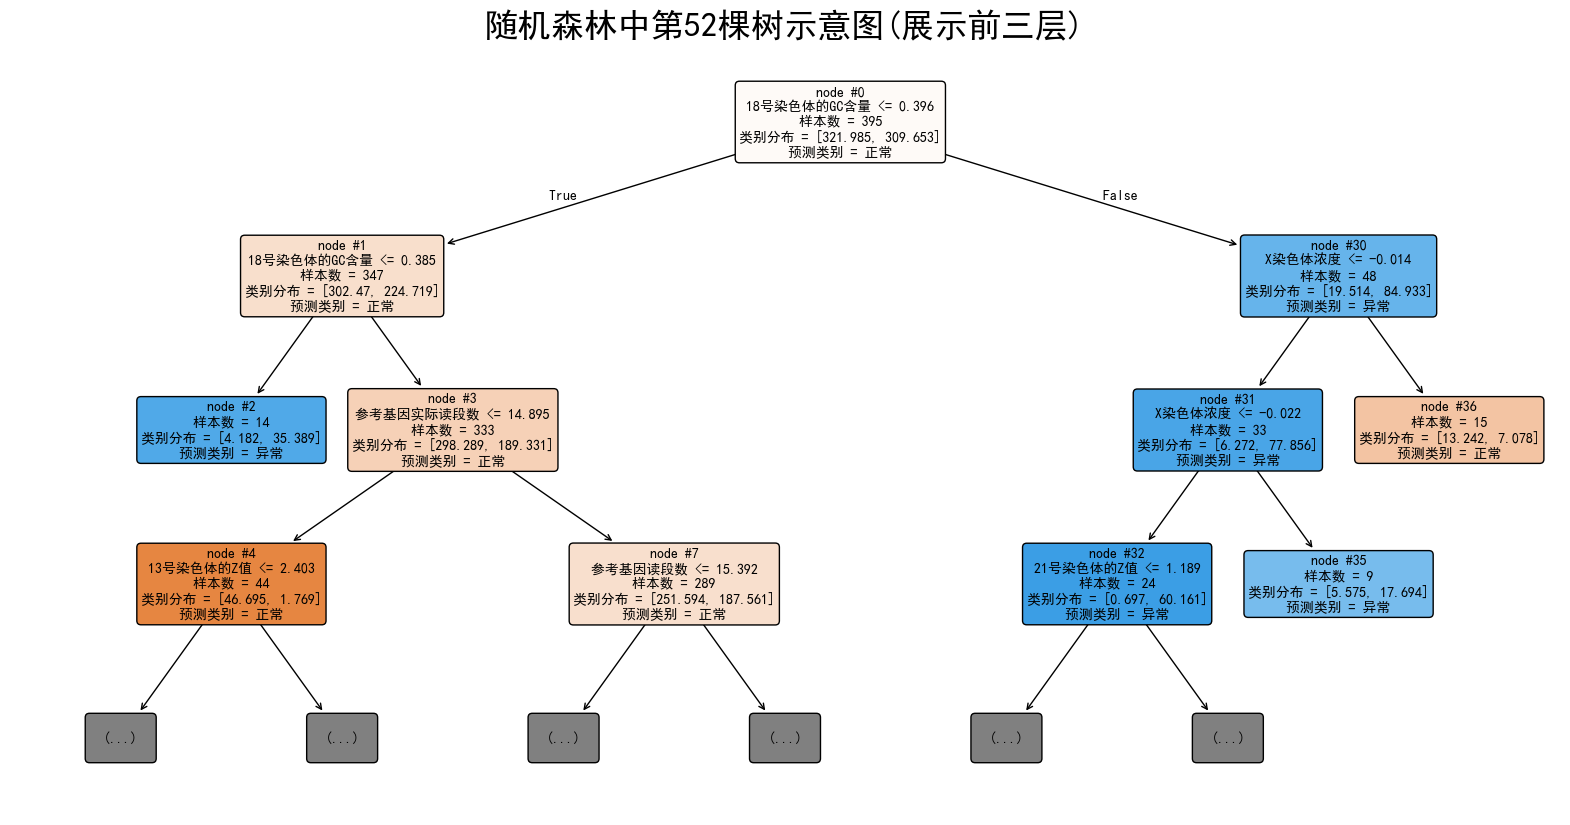

In [19]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[52], 
          feature_names=covars, 
          class_names=['正常', '异常'],
          filled=True, 
          rounded=True,
          max_depth=3,
          fontsize=10,
          impurity=False, 
          node_ids=True)

ax = plt.gca()
for text in ax.texts:
    content = text.get_text()
    content = content.replace('gini =', '基尼系数 =')
    content = content.replace('samples =', '样本数 =')
    content = content.replace('value =', '类别分布 =')
    content = content.replace('class =', '预测类别 =')
    content = content.replace('[', '[')  
    content = content.replace(']', ']')
    text.set_text(content)

plt.title("随机森林中第52棵树示意图(展示前三层)", fontsize=24)
plt.savefig("某棵树展示.png", format='png', dpi=400)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

im = plt.imshow(cm, cmap='Blues', interpolation='nearest')

plt.colorbar(im, fraction=0.046, pad=0.04)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), 
                ha='center', va='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black',
                fontsize=14, fontweight='bold')

plt.xticks([0, 1], ['正常', '异常'])
plt.yticks([0, 1], ['正常', '异常'])
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('混淆矩阵')

plt.grid(False)

plt.tight_layout()
plt.savefig('混淆矩阵.svg', format='svg')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_p)
plt.plot(fpr, tpr, label=f'ROC曲线 (AUC = {auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='随机猜测')
plt.xlabel('假正率')
plt.ylabel('真正率')
plt.title('ROC曲线')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc曲线.svg', format='svg')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_p)
plt.plot(recall_vals, precision_vals, label='PR曲线', linewidth=2)
plt.xlabel('召回率')
plt.ylabel('精确率')
plt.title('精确率-召回率曲线')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('精确率-召回率曲线.svg', format='svg')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
feature_importance = model.feature_importances_
feature_names = covars
indices = np.argsort(feature_importance)[::-1]

plt.barh(range(len(indices)), feature_importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('特征重要性')
plt.title('随机森林特征重要性排序')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('特征重要性.svg', format='svg')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(y_pred_p[y_test == 0], bins=30, alpha=0.7, label='正常样本', color='blue')
plt.hist(y_pred_p[y_test == 1], bins=30, alpha=0.7, label='异常样本', color='red')
plt.xlabel('预测概率')
plt.ylabel('频数')
plt.title('预测概率分布')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('预测概率分布.svg', format='svg')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
prob_true, prob_pred = calibration_curve(y_test, y_pred_p, n_bins=10)
plt.plot(prob_pred, prob_true, 's-', label='校准曲线')
plt.plot([0, 1], [0, 1], 'k--', label='完美校准')
plt.xlabel('预测概率')
plt.ylabel('真实概率')
plt.title('概率校准曲线')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('概率校准曲线.svg', format='svg')
plt.show()

In [ ]:
metrics = ['准确率', '精确率', '召回率', 'F1分数']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.ylim(0, 1)
plt.ylabel('分数')
plt.title('模型性能指标对比')
plt.grid(True, alpha=0.3, axis='y')

# 在柱子上添加数值标签
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('指标对比.svg', format='svg')
plt.show()


In [ ]:
print("\n=== 详细结果分析 ===")
print(f"1. AUC值为 {auc:.4f}，表明模型具有良好的区分能力")

# 混淆矩阵详细分析
tn, fp, fn, tp = cm.ravel()
print(f"2. 混淆矩阵分析:")
print(f"   - 真阴性(TN): {tn} (正确预测的正常样本)")
print(f"   - 假阳性(FP): {fp} (将正常误判为异常)")
print(f"   - 假阴性(FN): {fn} (将异常误判为正常)")
print(f"   - 真阳性(TP): {tp} (正确预测的异常样本)")

print(f"3. 特异性(真阴性率): {tn/(tn+fp):.4f}")
print(f"4. 阳性预测值: {precision:.4f}")
print(f"5. 阴性预测值: {tn/(tn+fn):.4f}")

# 特征重要性分析
print("\n6. 特征重要性分析:")
print("最重要的5个特征:")
for i in range(5):
    idx = indices[i]
    print(f"   {i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

# 模型应用建议
print("\n7. 模型应用建议:")
if recall > 0.95:
    print("   - 模型召回率很高，适合用于筛查场景")
elif precision > 0.95:
    print("   - 模型精确率很高，适合用于确诊场景")
else:
    print("   - 模型整体性能均衡，适合一般应用场景")

print(f"   - 建议关注F2分数({f2:.4f})，它在医疗场景中更重视召回率")

In [35]:
# print("\n=== 阈值优化 ===")
# for tar in targets:
#     y_pred_p = results[tar]['y_pred_p']
#     precision, recall, thresholds = precision_recall_curve(results[tar]['y_test'], y_pred_p)
    
#     # 找到保证高召回率的阈值
#     target_recall = 0.8  # 医疗诊断需要高召回率
#     optimal_idx = np.argmin(np.abs(recall[:-1] - target_recall))
#     optimal_threshold = thresholds[optimal_idx]
    
#     # 使用优化阈值重新预测
#     y_pred_optimized = (y_pred_p >= optimal_threshold).astype(int)
    
#     print(f"\n{tar} - 优化阈值: {optimal_threshold:.3f}")
#     print(f"召回率: {recall[optimal_idx]:.3f}, 精确率: {precision[optimal_idx]:.3f}")
#     print("优化后分类报告:")
#     print(classification_report(results[tar]['y_test'], y_pred_optimized))
    
#     # 更新结果
#     # results[tar]['optimal_threshold'] = optimal_threshold
#     # results[tar]['y_pred_optimized'] = y_pred_optimized


## 寻找t21 强相关特征

In [ ]:
# from scipy.stats import pointbiserialr

# feats = ["孕妇BMI", "X染色体的Z值", "X染色体浓度", "21号染色体的Z值", "18号染色体的GC含量", 
#         "13号染色体的GC含量", "参考基因唯一比对读段数", "21号染色体的GC含量", "13号染色体的Z值",
#         "检测孕周_天数", "T13", "T18", "IVF妊娠_编码", "末次月经_天数差"]

# correlation_results = []
# for feat in covars:
#     # 点二列相关计算
#     corr, p_value = pointbiserialr(df[feat], df['T21'])
#     correlation_results.append({
#         'feature': feat,
#         'correlation': corr,
#         'p_value': p_value,
#         'abs_correlation': abs(corr)
#     })

# # 创建DataFrame并排序
# corr_df = pd.DataFrame(correlation_results)
# corr_df = corr_df.sort_values('abs_correlation', ascending=False)

# print("特征与T21的点二列相关性排序:")
# print(corr_df[['feature', 'correlation', 'p_value']].head(10))

## 利用筛选的特征重新拟合 T21 的 Randomforest

In [ ]:
# feats = ["孕妇BMI", "X染色体的Z值", "X染色体浓度", "21号染色体的Z值", "18号染色体的GC含量", 
#         "13号染色体的GC含量", "参考基因唯一比对读段数", "21号染色体的GC含量", "13号染色体的Z值",
#         "检测孕周_天数", "T13", "T18", "IVF妊娠_编码", "末次月经_天数差"]

# # feats = ["T13", "T18", "检测孕周_天数", "末次月经_天数差"]

# x = df[feats]  
# y = df["T21"]  

# x_train, x_test, y_train, y_test = train_test_split(x,  y,  test_size=0.2, random_state=42, stratify=y)

# smote = SMOTE(random_state=42, sampling_strategy={1:100})
# X_train, Y_train = smote.fit_resample(x_train, y_train)

# model = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=8,            # 限制树深防止过拟合
#     min_samples_split=10,   # 增加分裂最小样本数
#     min_samples_leaf=10,     # 增加叶节点最小样本数
#     class_weight='balanced', # 类别权重平衡
#     random_state=42
# )

# model.fit(X_train, Y_train)
# models["new_T21"] = model

# # predict
# y_pred = model.predict(x_test)
# y_pred_p = model.predict_proba(x_test)[:, 1]

# auc = roc_auc_score(y_test, y_pred_p)
# report = classification_report(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)

# results["new_T21"] = {
#     'model': model,
#     'y_test': y_test,
#     'y_pred': y_pred,
#     'y_pred_p': y_pred_p,
#     'auc': auc,
#     'report': report,
#     'confusion_matrix': cm,
#     'x_test': x_test
# }

# print(f"\n=== new_T21 模型测试结果 ===")
# print(f"AUC: {auc:.3f}")
# print("分类报告:")
# print(report)


## 绘制roc-auc曲线

In [ ]:
# fig, axes = plt.subplots(3, 1, figsize=(14, 21))

# for i, tar in enumerate(targets):
#     y_test = results[tar]['y_test']
#     y_pred_p = results[tar]['y_pred_p']
    
#     # 计算ROC曲线和AUC
#     fpr, tpr, _ = roc_curve(y_test, y_pred_p)
#     roc_auc = roc_auc_score(y_test, y_pred_p)  # 直接计算ROC AUC
    
#     # # 计算PR曲线和AUC
#     # precision, recall, _ = precision_recall_curve(y_test, y_pred_p)
#     # pr_auc = auc(recall, precision)  # 必须这样计算PR AUC
    
#     # 绘制ROC曲线
#     axes[i].plot(fpr, tpr, color='darkorange', lw=2, 
#                     label=f'ROC (AUC = {roc_auc:.3f})')
#     axes[i].plot([0, 1], [0, 1], 'k--', label='Random')
#     axes[i].set_xlabel('False Positive Rate')
#     axes[i].set_ylabel('True Positive Rate')
#     axes[i].set_title(f'{tar} - ROC Curve')
#     axes[i].legend()
#     axes[i].grid(True)
    
#     # 绘制PR曲线
#     # positive_ratio = np.sum(y_test) / len(y_test)
#     # axes[1, i].plot(recall, precision, color='blue', lw=2, 
#     #                label=f'PR (AUC = {pr_auc:.3f})')
#     # axes[1, i].axhline(y=positive_ratio, color='red', linestyle='--', 
#     #                   label=f'Random ({positive_ratio:.3f})')
#     # axes[1, i].set_xlabel('Recall')
#     # axes[1, i].set_ylabel('Precision')
#     # axes[1, i].set_title(f'{tar} - Precision-Recall Curve')
#     # axes[1, i].legend()
#     # axes[1, i].grid(True)

# plt.tight_layout()
# plt.show()
